In [1]:
import sys
import copy
import time

from LossJLearn.base import TorchBaseEstimator
from LossJLearn.datasets import load_linear_data, load_data_from_func
from LossJLearn.utils.plot import (show_linear_point, 
                                   show_regressor_linear, 
                                   show_regressor_linear_sgd, 
                                   show_regression_line, 
                                   show_regressor_loss)
from LossJLearn.utils.translator import sec2time

%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

print("python version: ", sys.version_info)
print(torch.__name__, torch.__version__)

python version:  sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
torch 1.6.0


## 1. PyTorch1实现Linear Regression

### 1.1 TorchRegressorMixin

In [2]:
class TorchRegressorMixin:
    """Regressor Mixin with PyTorch. Mainly realized the score method."""

    def score(self, X_test, y_test):
        """Use test dataset to evaluate the trained model.

        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape.
            y_test: A np.ndarray array of (n_samples, ) shape. data type must be
                discrete value.
        Returns:
            return R^2, a np.ndarray float number. R^2 = 1 - u / v.
                u = sum((y_pred - y_true)^2), v = sum((y_true - y_true_mean)^2)
        """
        X_test, y_test = self._score_validation(X_test, y_test)
        y_pred = self.predict(X_test, _miss_valid=True)
        y_true_mean = torch.mean(y_test, axis=0)
        u = torch.sum(torch.square(y_pred - y_test))
        v = torch.sum(torch.square(y_test - y_true_mean))
        r_squared = 1 - u / v
        return r_squared.item()

### 1.2 TorchBaseLinearRegressor

In [3]:
class TorchBaseLinearRegressor(TorchBaseEstimator, TorchRegressorMixin):
    """Linear regressor base class with PyTorch, explicitly inherits from 
        TorchBaseEstimator and TorchRegressorMixin already.
    
    Attributes:
        _X_train:feature data for training. A torch.Tensor matrix of (n_samples, 
            n_features) shape, data type must be continuous value type. 
        _y_train:label data for training. A torch.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A torch.Tensor array of (n_features, ) shape.
        intercept_: intercept of regressor. A torch.Tensor float number.
    """

    def __init__(self, fit_intercept=True, random_state=None):
        """linear regressor init method.
        
        Args:
            fit_intercept: If use intercept in the linear regressor model. 
                A bool value, default = True
        """
        fit_intercept, random_state = self._init_validation(fit_intercept, random_state)
        self._X_train = None
        self._y_train = None
        self.coef_ = None
        if random_state is not None:
            torch.manual_seed(random_state)
        self.intercept_ = torch.randn([]) if fit_intercept else None

    def fit(self, X_train, y_train):
        """method for training model. 
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, 
                data type must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape.
        
        Returns:
            self object.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        if self.intercept_ is not None:
            self._X_train = torch.cat((self._X_train, torch.ones(self._X_train.shape[0], 1)), dim=1)
        self._calculate_coef()
        if self.intercept_ is not None:
            self.intercept_ = self.coef_[-1]
            self.coef_ = self.coef_[:-1]
            self._X_train = self._X_train[:, :-1]
        return self

    def predict(self, X_test, _miss_valid=False):
        """predict test data.
        
        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape, 
                or a np.ndarray array of (n_features, ) shape.
        """
        if not _miss_valid:
            X_test = self._predict_validation(X_test)
        product = X_test @ self.coef_
        return product if self.intercept_ is None else product + self.intercept_
    
    def _init_validation(self, fit_intercept, random_state):
        assert isinstance(fit_intercept, bool)
        assert isinstance(random_state, (int, type(None)))
        return fit_intercept, random_state

##### 合并多个Tensor

In [4]:
a = torch.tensor([[1,2,3], [4,5,6]])
b = torch.tensor([[1], [1]])
torch.cat((a, b), dim=1)

tensor([[1, 2, 3, 1],
        [4, 5, 6, 1]])

### 1.3 TorchLinearRegressor

In [5]:
class TorchLinearRegressor(TorchBaseLinearRegressor):
    """Linear regressor class with PyTorch, explicitly inherits from 
        TorchBaseLinearRegressor already.
    
    Attributes:
        _X_train:feature data for training. A torch.Tensor matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train:label data for training. A torch.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A torch.Tensor array of (n_features, ) shape.
        intercept_: intercept of regressor. A torch.Tensor float number.
    """

    def _calculate_coef(self):
        xtx = self._X_train.T @ self._X_train
        try:
            xtx_inv = torch.inverse(xtx)
        except RuntimeError as ex:
            raise ex
        self.coef_ = xtx_inv @ self._X_train.T @ self._y_train

In [6]:
X_data, y_data = load_linear_data(point_count=1000, min_=-100, max_=100, w=60.1842, b=-183.28, random_state=10384, scale=1000)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=18309)

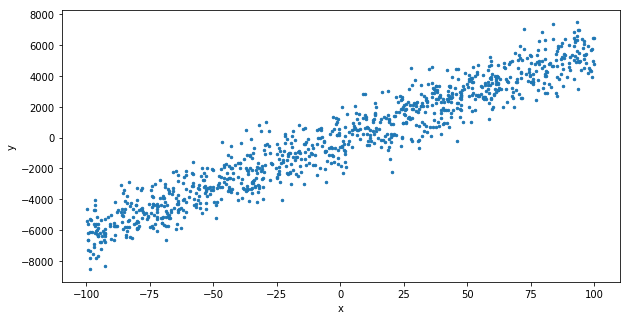

In [7]:
show_linear_point(X_data, y_data, s=6)

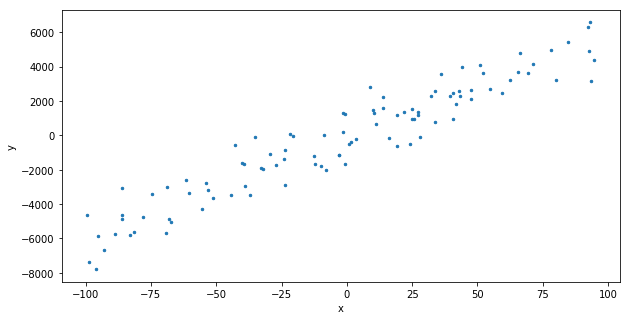

In [8]:
show_linear_point(X_data[:100], y_data[:100], s=6)

In [9]:
X_train[:10], y_train[:10]

(array([[ 25.92551488],
        [  9.1521136 ],
        [-94.55418001],
        [-92.47331603],
        [ 87.64979509],
        [ 65.64985861],
        [ 47.49646535],
        [-60.47215399],
        [ 61.79998174],
        [ 40.51698135]]),
 array([ 1872.29317225,  1259.1707385 , -6746.10586777, -5298.14906429,
         4468.13268928,  3666.63850735,  2754.07602806, -2438.87486027,
         3994.85883745,  1910.62617205]))

In [10]:
rgs = TorchLinearRegressor()
rgs.fit(X_train, y_train)
rgs.coef_, rgs.intercept_

(tensor([60.8624]), tensor(-146.4443))

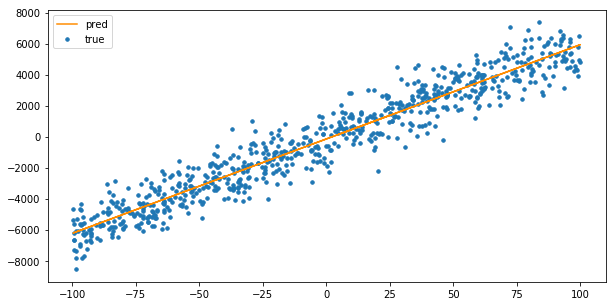

In [11]:
show_regressor_linear(X_train, y_train, pred_coef=rgs.coef_, pred_intercept=rgs.intercept_)

In [12]:
rgs.score(X_test, y_test)

0.915419340133667

In [13]:
rgs = TorchLinearRegressor(fit_intercept=False).fit(X_train, y_train)
rgs.coef_, rgs.intercept_

(tensor([60.9723]), None)

In [14]:
# boston
X_data, y_data = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=18309)
rgs = TorchLinearRegressor().fit(X_train, y_train)
rgs.score(X_test, y_test)

0.7576017379760742

In [15]:
rgs.coef_, rgs.intercept_

(tensor([-1.4766e-02,  5.2120e-02,  8.1271e-02,  2.8645e+00, -1.6548e+01,
          3.9098e+00,  4.4427e-03, -1.4850e+00,  2.8716e-01, -1.4569e-02,
         -8.5995e-01,  1.1012e-02, -5.9579e-01]), tensor(33.7335))

In [16]:
rgs.predict(X_test[:10])

tensor([17.0758, 22.2702, 18.2579, 36.3211, 43.7982, 22.4350, 25.3666, 34.3343,
        15.8240, 29.0283])

##### 求逆矩阵

In [17]:
a = torch.zeros(2,2)
b = torch.eye(2)
torch.inverse(a + b)

tensor([[1., -0.],
        [0., 1.]])

In [18]:
a = torch.zeros(2,2)
torch.inverse(a)

RuntimeError: inverse_cpu: U(1,1) is zero, singular U.

### 2. PyTorch实现Ridge

In [19]:
class TorchRidge(TorchBaseLinearRegressor):
    """Ridge class with PyTorch. explicitly inherits from TorchBaseLinearRegressor already.
    
    Attributes:
        _X_train:feature data for training. A torch.Tensor matrix of (n_samples, n_features)
            shape, data type must be continuous value type. 
        _y_train:label data for training. A torch.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A torch.Tensor array of (n_features, ) shape.
        intercept_: intercept of regressor. A torch.Tensor float number.
        alpha: the regularize rate. A positive float number, default = 1.0.
    """

    def __init__(self, fit_intercept=True, alpha=1.0, random_state=None):
        """ridge object init method.
        
        Args:
            fit_intercept: Bool value. If use intercept in the ridge model.
            alpha: the regularize rate. A positive float number, default = 1.0.
        
        Raises:
            AssertionError: Alpha value must be a number.
            ValueError: Alpha value must be greater than 0.
        """
        super().__init__(fit_intercept=fit_intercept, random_state=random_state)
        assert isinstance(alpha, int) or isinstance(alpha, float)
        if 0 < alpha:
            self.alpha = alpha
        else:
            raise ValueError("Alpha value must be greater than 0! ")

    def _calculate_coef(self):
        xtx = self._X_train.T @ self._X_train
        self.coef_ = (
            torch.inverse(xtx + self.alpha * torch.eye(self._X_train.shape[1])) \
            @ self._X_train.T \
            @ self._y_train
        )

In [20]:
X_data, y_data = load_linear_data(point_count=1000, min_=-100, max_=100, w=60.1842, b=-183.28, random_state=10384, scale=1000)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=18309)

In [21]:
rgs = TorchRidge(alpha=1.0).fit(X_train, y_train)
rgs.score(X_test, y_test)

0.9154180288314819

In [22]:
rgs.coef_, rgs.intercept_

(tensor([60.8625]), tensor(-146.2491))

In [23]:
# boston
X_data, y_data = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=18309)
rgs = TorchRidge().fit(X_train, y_train)
rgs.score(X_test, y_test)

0.7315092086791992

## 3. PyTorch实现SGD Linear Regression

### 3.1 PyTorch API

#### 3.1.1 计算loss

https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss

In [24]:
y = torch.tensor([1., 2.])
y_pred = torch.tensor([2., 3.])
F.mse_loss(y, y_pred)

tensor(1.)

In [25]:
criterion = nn.MSELoss(reduction="mean")
criterion(y, y_pred)

tensor(1.)

In [26]:
y2 = torch.tensor([0., 0.])
y2_pred = torch.tensor([0., 0.])
criterion(y2, y2_pred) # 没有tf.metrics累加求平均的功能

tensor(0.)

In [27]:
criterion = nn.MSELoss(reduction="sum")
criterion(y, y_pred)

tensor(2.)

In [28]:
criterion = nn.MSELoss(reduction="none")
criterion(y, y_pred)

tensor([1., 1.])

#### 3.1.2 自动求导

In [29]:
w = torch.tensor([10.], requires_grad=True)
x = torch.tensor([[1.]])
y = torch.tensor([2.])

y_pred = x @ w
loss = F.mse_loss(y, y_pred)
loss.backward()
w.grad

tensor([16.])

#### 3.1.3 优化器（更新参数）

In [30]:
w = torch.tensor([10.], requires_grad=True)
x = torch.tensor([[1.]])
y = torch.tensor([2.])

learning_rate = 0.1
optimizer = torch.optim.SGD(params=[w], lr=learning_rate)

y_pred = x @ w
optimizer.zero_grad()
loss = F.mse_loss(y, y_pred)
loss.backward()
optimizer.step()
w

tensor([8.4000], requires_grad=True)

#### 3.1.4 加载数据集

In [31]:
class TorchBaseDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__(self):
        return self.y_data.shape[0]

In [32]:
train_dataset = TorchBaseDataset(torch.as_tensor(X_train), torch.as_tensor(y_train))

In [33]:
for x, y in train_dataset:
    print(x, y)
    break

tensor([ 11.1604,   0.0000,  18.1000,   0.0000,   0.7400,   6.6290,  94.6000,
          2.1247,  24.0000, 666.0000,  20.2000, 109.8500,  23.2700],
       dtype=torch.float64) tensor(13.4000, dtype=torch.float64)


#### 3.1.5 生成batch

In [34]:
batch_size = 32

train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [35]:
len(train_data_loader)

12

In [36]:
for X_train_batch, y_train_batch in train_data_loader:
    print(X_train_batch, y_train_batch)
    break

tensor([[1.2744e-01, 0.0000e+00, 6.9100e+00, 0.0000e+00, 4.4800e-01, 6.7700e+00,
         2.9000e+00, 5.7209e+00, 3.0000e+00, 2.3300e+02, 1.7900e+01, 3.8541e+02,
         4.8400e+00],
        [2.5199e-01, 0.0000e+00, 1.0590e+01, 0.0000e+00, 4.8900e-01, 5.7830e+00,
         7.2700e+01, 4.3549e+00, 4.0000e+00, 2.7700e+02, 1.8600e+01, 3.8943e+02,
         1.8060e+01],
        [4.8357e+00, 0.0000e+00, 1.8100e+01, 0.0000e+00, 5.8300e-01, 5.9050e+00,
         5.3200e+01, 3.1523e+00, 2.4000e+01, 6.6600e+02, 2.0200e+01, 3.8822e+02,
         1.1450e+01],
        [1.2236e+00, 0.0000e+00, 1.9580e+01, 0.0000e+00, 6.0500e-01, 6.9430e+00,
         9.7400e+01, 1.8773e+00, 5.0000e+00, 4.0300e+02, 1.4700e+01, 3.6343e+02,
         4.5900e+00],
        [6.0760e-02, 0.0000e+00, 1.1930e+01, 0.0000e+00, 5.7300e-01, 6.9760e+00,
         9.1000e+01, 2.1675e+00, 1.0000e+00, 2.7300e+02, 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [4.6296e-01, 0.0000e+00, 6.2000e+00, 0.0000e+00, 5.0400e-01, 7.4120e+00,

#### 3.1.6 切分数据集

In [37]:
# Sampler indices
X_data, y_data = load_linear_data(point_count=100)
dataset = TorchBaseDataset(X_data, y_data)

dataset_size = len(dataset)
idx = list(range(dataset_size))
train_size = int(dataset_size * 0.8)
valid_size = dataset_size - train_size
# np.random.shuffle(idx)
train_idx, valid_idx = idx[:train_size], idx[train_size:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [38]:
# random_split

X_data, y_data = load_linear_data(point_count=100)
dataset = TorchBaseDataset(X_data, y_data)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
valid_size = dataset_size - train_size

train_dataset, valid_dataset = random_split(dataset, lengths=[train_size, valid_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 3.1.7 正则化

In [39]:
w = torch.tensor([10.], requires_grad=True)
optimizer = torch.optim.SGD(params=[w], lr=learning_rate, weight_decay=0.01) # default l2 regularize

In [40]:
def l2_term(w):
    return torch.sum(torch.square(w))

def l1_term(w):
    return torch.sum(torch.abs(w))

# loss = loss + l2_term(w)

In [41]:
l2_term(w)

tensor(100., grad_fn=<SumBackward0>)

In [42]:
l1_term(w)

tensor(10., grad_fn=<SumBackward0>)

### 3.2 TorchSGDRegressor

In [43]:
class TorchSGDRegressor(TorchBaseLinearRegressor):
    """Linear SGD regressor class with tensorflow, explicitly inherits 
        from TFBaseLinearRegressor already.
    
    Attributes:
        _X_train:feature data for training. A torch.Tensor matrix of (n_samples,
            n_features) shape, data type must be continuous value type. 
        _y_train:label data for training. A torch.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A torch.Tensor matrix of (n_features, 1) shape.
        intercept_: intercept of regressor. A torch.Tensor integer if intercept_ is 
            not None else None.
        alpha: the regularize rate. A float number and must be greater than 0, 
            default = 0.001.
        save_param_list: if save param of the train process. A bool value, default = True.
        coef_list: list of coef param from the train process,
            every coef is a np.ndarray of (n_features, ) shape.
        intercept_list: list of intercept param from the train process, 
            every intercept is a np.ndarray float number.
        learning_rate: learning rate. A positive float number, default = 0.001.
        epochs: epochs. A positive int number, default = 10.
        batch_size: batch size. A positive int number, default = 32.
        early_stopping: if early stopping when loss don't reduce again. A bool value,
            default = True.
        patient: Number of epochs that do not reduce loss continuously, 
            patient only takes effect when early_stopping is True. 
            A positive int number, default = 5.
        toc: The threshold that symbolizes loss no longer decreases, 
            toc only takes effect when early_stopping is True. 
            A float number, default = 0.001
        random_state: random seed. A positive int number if random_state 
            is not None else None, default = None.
        regularize: regularize. A str value in {"l1", "l2"} if regularize 
            is not None else None, default = None.
        best_loss: best loss of the train process. A np.ndarray float number.
        best_coef: best coef of the train process. A torch.Tensor array of 
            (n_features, 1) shape.
        best_intercept_: best intercept of the train process. A torch.Tensor number.
        train_loss: list of train loss from the train process. 
            every loss is a np.ndarray float number.
        valid_loss: list of valid loss from the train process.
            every loss is a np.ndarray float number.
        n_iter: the actual iteration of train process. A int number, initial = 0.
        save_best_model: if save the best model params as the final model.
                A bool value, defalut = True.
    """
    
    def __init__(
        self,
        loss="mse",
        alpha=0.001,
        fit_intercept=True,
        save_param_list=True,
        learning_rate=0.001,
        epochs=10,
        batch_size=32,
        early_stopping=True,
        patient=5,
        toc=0.001,
        random_state=None,
        regularize=None,
        save_best_model=True
    ):
        """TorchSGDRegressor initial method.
        
        Args:
            loss: A str in {"mse"}, default = "mse"
            alpha: the regularize rate. A float number and must be greater
                than 0, default = 0.001.
            fit_intercept: if fit intercept. A bool value, default = True. 
            save_param_list: if save param of the train process. A bool value,
                default = True.
            learning_rate: learning rate. A positive float number, default = 0.001.
            epochs: epochs. A positive int number, default = 10.
            batch_size: batch size. A positive int number, default = 32.
            early_stopping: if early stopping when loss don't reduce again. 
                A bool value, default = True
            patient: Number of epochs that do not reduce loss continuously, 
                patient only takes effect when early_stopping is True. 
                A positive int number, default = 5.
            toc: The threshold that symbolizes loss no longer decreases, 
                toc only takes effect when early_stopping is True. 
                A float number, default = 0.001
            random_state: random seed. A positive int number if random_state 
                is not None else None, default = None.
            regularize: regularize. A str value in {"l1", "l2"} if regularize 
                is not None else None, default = None.
            save_best_model: if save the best model params as the final model.
                A bool value, defalut = True
        
        Raises:
            AssertionError: Some parameters do not match.
        """
        (
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            save_best_model
        ) = self._init_validation(
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            save_best_model
        )
        self.random_state = random_state
        if isinstance(self.random_state, int):
            torch.manual_seed(self.random_state)
        
        loss_func_dict = {"mse": F.mse_loss}
        self._loss_func = loss_func_dict[loss]
        
        self.alpha = alpha
        
        self.intercept_ = None
        if fit_intercept:
            self.intercept_ = torch.normal(mean=0.0, std=1.0, size=[]).requires_grad_()
        
        self.save_param_list = save_param_list
        self.coef_list = []
        self.intercept_list = []
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.patient = patient
        self.toc = toc
        
        self.regularize = regularize
        self._regularizer = lambda: 0
        if self.regularize:
            reg_dict = {"l1": self._l1_term, "l2": self._l2_term}
            self._regularizer = reg_dict[self.regularize]
            
        self.save_best_model = save_best_model
        
        self._X_train = None
        self._y_train = None
        
        self.coef_ = None

        self._optimizer = None
        
        self.best_loss = torch.tensor(float("inf")).item()
        self.best_coef_ = None
        self.best_intercept_ = None
        self.train_loss = []
        self.valid_loss = []
        
        self.n_iter = 0
        
    def _l1_term(self, w):
        return self.alpha * torch.sum(torch.abs(w))
    
    def _l2_term(self, w):
        return self.alpha * torch.sum(torch.square(w))

    def fit(self, X_train, y_train, validation=None):
        """train model methed.
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, 
                data type must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape, data type 
                must be continuous value type.
            validation: the validation data for validate the model. A tuple
                like (X_valid, y_valid) , the shape of X_valid and y_valid is 
                like X_train and y_train. Default = None.
        
        Returns:
            return self object.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        X_train, y_train = self._X_train, self._y_train
        if self.coef_ is None:
            self.coef_ = torch.normal(mean=0.0, std=1.0, size=(self._X_train.shape[1], )).requires_grad_()
        if self._optimizer is None:
            params = [self.coef_] if self.intercept_ is None else [self.coef_, self.intercept_]
            self._optimizer = torch.optim.SGD(params=params, lr=self.learning_rate)
        train_dataset, valid_dataset = self._validation_valid(validation, X_train, y_train)
        
        steps_per_epoch = self._X_train.shape[0] // self.batch_size
        if self.early_stopping:
            current_patient = 0 
            last_val_loss = 0

        valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False)
        for epoch in range(self.epochs):
            # 1. train
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            epoch_time = 0
            print(f"Epoch {epoch + 1}/{self.epochs}")
            train_sum_loss = 0
            for step, (X_train_batch, y_train_batch) in enumerate(train_loader):
                start = time.time()
                train_sum_loss = self._fit_step(X_train_batch, y_train_batch, train_sum_loss)
                train_mean_loss = train_sum_loss / (step + 1)
                epoch_time, mean_step_time = self._step_print(steps_per_epoch, step, epoch_time, start, train_mean_loss)
            
            # 2. valid
            val_loss = self._epoch_valid_and_print(epoch_time, mean_step_time, steps_per_epoch, train_mean_loss, valid_loader)
            
            # 3. save train process
            self._save_train_process(val_loss, train_mean_loss)
            
            self.n_iter += 1
            
            # 4. early stopping
            if self.early_stopping:
                if epoch != 0:
                    if last_val_loss - val_loss < self.toc:
                        current_patient += 1
                    else:
                        current_patient = 0
                    if current_patient >= self.patient:
                        break
                last_val_loss = val_loss
        
        if self.save_best_model:
            self._save_best_params()
        return self
    
    def _save_best_params(self):
        self.coef_ = copy.deepcopy(self.best_coef_)
        if self.intercept_ is not None:
            self.intercept_ = copy.deepcopy(self.best_intercept_)
    
    def _save_train_process(self, val_loss, train_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss.item()
            self.best_coef_ = copy.deepcopy(self.coef_)
            if self.intercept_ is not None:
                self.best_intercept_ = copy.deepcopy(self.intercept_)
        if self.save_param_list:
            self.coef_list.append(copy.deepcopy(self.coef_.detach().numpy()))
            if self.intercept_ is not None:
                self.intercept_list.append(copy.deepcopy(self.intercept_.item()))
            self.train_loss.append(train_loss)
            self.valid_loss.append(val_loss)
    
    def _validation_valid(self, validation, X_train, y_train):
        dataset = TorchBaseDataset(X_train, y_train)
        if validation is None:
            n_samples = int(self._X_train.shape[0] * 0.8)
            train_dataset, valid_dataset = random_split(
                dataset=dataset, lengths=[n_samples, self._X_train.shape[0] - n_samples])
        else:
            X_valid, y_valid = self._fit_validation(*validation)
            train_dataset = dataset
            valid_dataset = TorchBaseDataset(X_valid, y_valid)
        return train_dataset, valid_dataset

    def _call(self, X):
        y = torch.matmul(X, self.coef_)
        if self.intercept_ is not None:
            y = torch.add(y, self.intercept_)
        return y

    def _init_validation(
        self,
        loss,
        alpha,
        fit_intercept,
        save_param_list,
        learning_rate,
        epochs,
        batch_size,
        early_stopping,
        patient,
        toc,
        random_state,
        regularize,
        save_best_model,
    ):
        assert loss in {"mse"}
        assert isinstance(alpha, (int, float)) and 0 < alpha
        assert isinstance(fit_intercept, bool)
        assert isinstance(save_param_list, bool)
        assert isinstance(learning_rate, float) and 0 < learning_rate <= 1.0
        assert isinstance(epochs, int) and epochs >= 1
        assert isinstance(batch_size, int) and batch_size >= 1
        assert isinstance(early_stopping, bool)
        assert isinstance(patient, int) and patient >= 2
        assert isinstance(toc, (int, float)) and 0 < toc
        assert isinstance(random_state, (type(None), int))
        if isinstance(random_state, int):
            assert random_state >= 0
        assert regularize in {"l2", "l1", None}
        assert isinstance(save_best_model, bool)
        return (
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            save_best_model
        )
    
    def _fit_step(self, X_train_batch, y_train_batch, train_sum_loss):
        # 1.calculate loss 
        y_pred_batch = self._call(X_train_batch)
        loss = self._loss_func(y_train_batch, y_pred_batch)
        if self.regularize:
            loss += self._regularizer(self.coef_)
        
        # optimizer clean gradient
        self._optimizer.zero_grad()
        # 2.calculate gradients by loss
        loss.backward()
        # 3.use optimizer to update params by gradients
        self._optimizer.step()
        
        # 4.use metric to calculate the mean loss for output
        train_sum_loss += loss
        return train_sum_loss
        
    def _step_print(self, steps_per_epoch, step, epoch_time, start, train_mean_loss):
        steps_str_len = len(str(steps_per_epoch))
        done_count = int((step + 1) / steps_per_epoch * 30)
        done_str = "=" * done_count
        to_do_str = "." * (30 - 1 - done_count)
        end = time.time()
        step_time = end - start
        epoch_time += step_time
        mean_step_time = epoch_time / (step + 1)
        remain_time = (steps_per_epoch - (step + 1)) * mean_step_time
        remain_time = sec2time(remain_time)
        print(
            f"\r{step + 1:{steps_str_len}}/{steps_per_epoch} [{done_str}>{to_do_str}] - ETA: {remain_time} - loss: {train_mean_loss:.4f}",
            end="",
        )
        return epoch_time, mean_step_time
    
    def _epoch_valid_and_print(self, epoch_time, mean_step_time, steps_per_epoch, train_mean_loss, valid_loader):
        valid_mean_loss = 0
        for valid_step, (X_valid_batch, y_valid_batch) in enumerate(valid_loader):
            y_valid_pred = self._call(X_valid_batch)
            loss = self._loss_func(y_valid_batch, y_valid_pred)
            valid_mean_loss += loss
        valid_mean_loss /= (valid_step + 1)
        epoch_time = sec2time(epoch_time)
        mean_step_time = sec2time(mean_step_time)
        print(
            f"\r{steps_per_epoch}/{steps_per_epoch} [{'=' * 30}] - {epoch_time} {mean_step_time}/step - loss: {train_mean_loss:.4f} - val_loss: {valid_mean_loss:.4f}"
        )
        return valid_mean_loss

#### 3.2.1 拟合直线

In [44]:
x, y = load_linear_data(500, w=0.5493, b=1.1973)
# x, y = load_linear_data(point_count=1000, min_=-100, max_=100, w=60.1842, b=-183.28, random_state=10384, scale=1000)

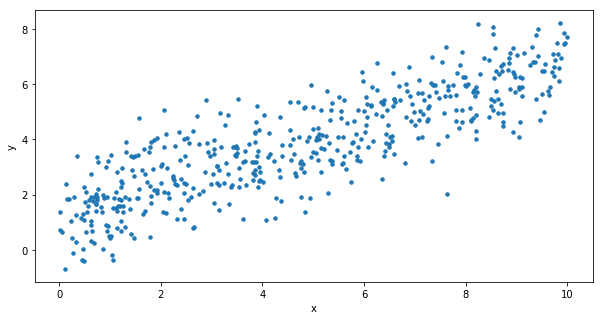

In [45]:
show_linear_point(x, y)

##### 3.2.1.1 线性回归

In [46]:
rgs = TorchSGDRegressor(batch_size=32, learning_rate=0.01, random_state=11883, epochs=100, early_stopping=True, toc=0.01).fit(x, y)

Epoch 1/100
15/15 [==============================] - 4ms 313us/step - loss: 8.7425 - val_loss: 1.5133
Epoch 2/100
15/15 [==============================] - 3ms 290us/step - loss: 1.5138 - val_loss: 1.4359
Epoch 3/100
15/15 [==============================] - 3ms 287us/step - loss: 1.4561 - val_loss: 1.3859
Epoch 4/100
15/15 [==============================] - 3ms 277us/step - loss: 1.3662 - val_loss: 1.3136
Epoch 5/100
15/15 [==============================] - 3ms 282us/step - loss: 1.3788 - val_loss: 1.2602
Epoch 6/100
15/15 [==============================] - 3ms 294us/step - loss: 1.3010 - val_loss: 1.2202
Epoch 7/100
15/15 [==============================] - 3ms 281us/step - loss: 1.2754 - val_loss: 1.2790
Epoch 8/100
15/15 [==============================] - 3ms 286us/step - loss: 1.2255 - val_loss: 1.1621
Epoch 9/100
15/15 [==============================] - 4ms 354us/step - loss: 1.1879 - val_loss: 1.1891
Epoch 10/100
15/15 [==============================] - 6ms 492us/step - loss: 1.210

In [47]:
rgs.coef_, rgs.intercept_

(tensor([0.5506], requires_grad=True), tensor(1.1821, requires_grad=True))

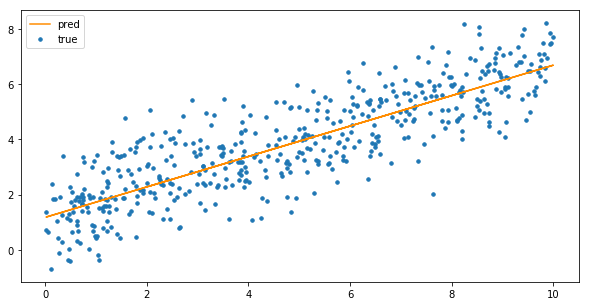

In [48]:
show_regressor_linear(x, y, pred_coef=rgs.coef_.detach().numpy(), pred_intercept=rgs.intercept_.detach().numpy())

##### 3.2.1.2 正则化

In [49]:
rgs = TorchSGDRegressor(batch_size=32, learning_rate=0.01, random_state=11883, epochs=10, early_stopping=True, toc=0.01, regularize="l2").fit(x, y)

Epoch 1/10
15/15 [==============================] - 5ms 419us/step - loss: 8.7430 - val_loss: 1.5133
Epoch 2/10
15/15 [==============================] - 4ms 377us/step - loss: 1.5144 - val_loss: 1.4359
Epoch 3/10
15/15 [==============================] - 5ms 437us/step - loss: 1.4567 - val_loss: 1.3858
Epoch 4/10
15/15 [==============================] - 6ms 487us/step - loss: 1.3667 - val_loss: 1.3135
Epoch 5/10
15/15 [==============================] - 5ms 427us/step - loss: 1.3792 - val_loss: 1.2601
Epoch 6/10
15/15 [==============================] - 6ms 524us/step - loss: 1.3015 - val_loss: 1.2201
Epoch 7/10
15/15 [==============================] - 5ms 421us/step - loss: 1.2758 - val_loss: 1.2789
Epoch 8/10
15/15 [==============================] - 5ms 422us/step - loss: 1.2259 - val_loss: 1.1620
Epoch 9/10
15/15 [==============================] - 5ms 417us/step - loss: 1.1882 - val_loss: 1.1890
Epoch 10/10
15/15 [==============================] - 7ms 609us/step - loss: 1.2109 - val_lo

In [50]:
rgs = TorchSGDRegressor(batch_size=32, learning_rate=0.01, random_state=11883, epochs=10, early_stopping=True, toc=0.01, regularize="l1").fit(x, y)

Epoch 1/10
15/15 [==============================] - 5ms 436us/step - loss: 8.7432 - val_loss: 1.5133
Epoch 2/10
15/15 [==============================] - 5ms 394us/step - loss: 1.5146 - val_loss: 1.4359
Epoch 3/10
15/15 [==============================] - 4ms 382us/step - loss: 1.4569 - val_loss: 1.3858
Epoch 4/10
15/15 [==============================] - 4ms 375us/step - loss: 1.3669 - val_loss: 1.3135
Epoch 5/10
15/15 [==============================] - 4ms 348us/step - loss: 1.3794 - val_loss: 1.2602
Epoch 6/10
15/15 [==============================] - 5ms 386us/step - loss: 1.3017 - val_loss: 1.2201
Epoch 7/10
15/15 [==============================] - 6ms 474us/step - loss: 1.2760 - val_loss: 1.2789
Epoch 8/10
15/15 [==============================] - 5ms 436us/step - loss: 1.2262 - val_loss: 1.1620
Epoch 9/10
15/15 [==============================] - 5ms 390us/step - loss: 1.1885 - val_loss: 1.1890
Epoch 10/10
15/15 [==============================] - 4ms 355us/step - loss: 1.2111 - val_lo

In [51]:
rgs.coef_list[:10]

[array([0.7447912], dtype=float32),
 array([0.7346506], dtype=float32),
 array([0.7528764], dtype=float32),
 array([0.7076801], dtype=float32),
 array([0.6975562], dtype=float32),
 array([0.7098279], dtype=float32),
 array([0.7400947], dtype=float32),
 array([0.702241], dtype=float32),
 array([0.7154991], dtype=float32),
 array([0.696742], dtype=float32)]

In [52]:
rgs.intercept_list[:10]

[-0.19446848332881927,
 -0.10055437684059143,
 -0.007162890397012234,
 0.06747806072235107,
 0.1456954926252365,
 0.22075162827968597,
 0.2946067750453949,
 0.3518081605434418,
 0.41054725646972656,
 0.4635685682296753]

##### 3.2.1.3 不同学习率对学习过程的影响

In [53]:
import numpy as np

In [54]:
def show_diff_lr_params(lr_w1_list, lr_w2_list, lr_list, w1_name="coef", w2_name="intercept", true_w1=0.5493, true_w2=1.1973):
    """show params' change on different learning rate.
    
    Args:
        lr_w1_list: the list of different w1 list(rgs.coef_list).
        lr_w2_list: the list of different w1 list(rgs.intercept_list).
        lr_list: the list the learning rate. learning rate is a number. 
            e.g: [0.1, 0.01, 0.001, 0.0001].
        w1_name: the name of w1. A str value, default = "coef".
        w2_name: the name of w1. A str value, default = "intercept".
        true_w1: the true w1 value. A number, default = 0.5493.
        true_w2: the true w2 value. A number, default = 1.1973.
    """
    assert isinstance(lr_w1_list, list) and lr_w1_list
    assert isinstance(lr_w2_list, list) and lr_w2_list
    plt.style.use('ggplot')
    plt.figure(figsize=[16, 8])
    plt.xlabel(w1_name)
    plt.ylabel(w2_name)
    for w1_list, w2_list, lr in zip(lr_w1_list, lr_w2_list, lr_list):
        w1_list = [w1[0] if (isinstance(w1, np.ndarray) and w1.ndim >= 1) else w1 for w1 in w1_list]
        w2_list = [w2[0] if (isinstance(w2, np.ndarray) and w2.ndim >= 1) else w2 for w2 in w2_list]
        plt.plot(w1_list, w2_list, label=str(lr) if not isinstance(lr, str) else lr)
    plt.scatter(true_w1, true_w2, s=20, label="true params")
    plt.legend()
    plt.show()

In [55]:
lr_list = [1., 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
lr_coef_list = []
lr_intercept_list = []
for idx, lr in enumerate(lr_list[2:]):
    print("-" * 100)
    exec(f"rgs{idx} = TorchSGDRegressor(random_state=10930, learning_rate={lr}, epochs=300)")
    exec(f"rgs{idx}.fit(x, y)")
    exec(f"lr_coef_list.append(rgs{idx}.coef_list)")
    exec(f"lr_intercept_list.append(rgs{idx}.intercept_list)")

----------------------------------------------------------------------------------------------------
Epoch 1/300
15/15 [==============================] - 3ms 302us/step - loss: 1.9146 - val_loss: 1.6315
Epoch 2/300
15/15 [==============================] - 4ms 318us/step - loss: 1.4017 - val_loss: 1.6200
Epoch 3/300
15/15 [==============================] - 4ms 310us/step - loss: 1.3628 - val_loss: 1.5039
Epoch 4/300
15/15 [==============================] - 3ms 283us/step - loss: 1.2839 - val_loss: 1.4999
Epoch 5/300
15/15 [==============================] - 3ms 302us/step - loss: 1.2324 - val_loss: 1.4298
Epoch 6/300
15/15 [==============================] - 3ms 273us/step - loss: 1.1964 - val_loss: 1.5847
Epoch 7/300
15/15 [==============================] - 4ms 314us/step - loss: 1.1655 - val_loss: 1.4292
Epoch 8/300
15/15 [==============================] - 4ms 381us/step - loss: 1.1611 - val_loss: 1.7143
Epoch 9/300
15/15 [==============================] - 5ms 402us/step - loss: 1.1193 

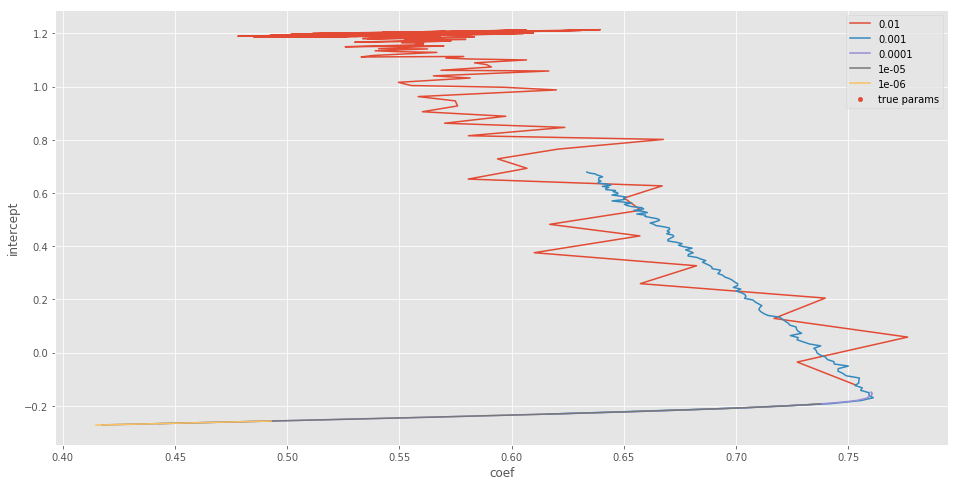

In [56]:
show_diff_lr_params(lr_coef_list, lr_intercept_list, lr_list[2:])

#### 3.2.2 boston房价预测

In [57]:
# boston
X_data, y_data = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=1831)
rgs = TorchSGDRegressor().fit(X_train, y_train)

Epoch 1/10
11/11 [==============================] - 3ms 322us/step - loss: inf - val_loss: inf79042816.0000
Epoch 2/10
11/11 [==============================] - 3ms 301us/step - loss: nan - val_loss: nan
Epoch 3/10
11/11 [==============================] - 3ms 316us/step - loss: nan - val_loss: nan
Epoch 4/10
11/11 [==============================] - 2ms 296us/step - loss: nan - val_loss: nan
Epoch 5/10
11/11 [==============================] - 3ms 315us/step - loss: nan - val_loss: nan
Epoch 6/10
11/11 [==============================] - 2ms 295us/step - loss: nan - val_loss: nan
Epoch 7/10
11/11 [==============================] - 2ms 284us/step - loss: nan - val_loss: nan
Epoch 8/10
11/11 [==============================] - 3ms 322us/step - loss: nan - val_loss: nan
Epoch 9/10
11/11 [==============================] - 3ms 386us/step - loss: nan - val_loss: nan
Epoch 10/10
11/11 [==============================] - 3ms 332us/step - loss: nan - val_loss: nan


##### 3.2.2.1 Numpy实现StandardScaler

In [58]:
import numpy as np 

class NumpyStandardScaler:
    """Standard Normalization Scaler with Numpy

        Attributes:
            mean_: The mean vector of features, with (feature_count, ) shape.
            scale_: The scale vector of features, with (feature_count, ) shape.
        """

    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X_train):
        """Fit the scaler from X_train data.

        Args:
            X_train: The train data of features, with (sample_count, feature_count) shape.
        """
        self.mean_ = np.mean(X_train, axis=0)
        self.scale_ = np.sqrt(np.mean(np.square(X_train - self.mean_), axis=0))

    def transform(self, X):
        """Transform X data.

        Args:
            X: The data of features, with (sample_count, feature_count) shape.

        Returns:
            A new matrix with transformation, with the same shape of old X.
        """
        return (X - self.mean_) / (self.scale_ + 0.000001)

    def fit_transform(self, X_train):
        """Fit and Transform X_train data.

        Args:
            X_train: The train data of features, with (sample_count, feature_count) shape.

        Returns:
            A new matrix with transformation, with the same shape of old X_train.
        """
        self.fit(X_train)
        return self.transform(X_train)

In [59]:
scaler = NumpyStandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [60]:
rgs = TorchSGDRegressor(learning_rate=0.01, epochs=40, random_state=1938).fit(X_train_scaler, y_train)

Epoch 1/40
11/11 [==============================] - 3ms 366us/step - loss: 539.0146 - val_loss: 514.7437
Epoch 2/40
11/11 [==============================] - 3ms 303us/step - loss: 346.9947 - val_loss: 369.6959
Epoch 3/40
11/11 [==============================] - 4ms 415us/step - loss: 229.4471 - val_loss: 278.3241
Epoch 4/40
11/11 [==============================] - 3ms 351us/step - loss: 156.2770 - val_loss: 214.7578
Epoch 5/40
11/11 [==============================] - 3ms 304us/step - loss: 113.8491 - val_loss: 170.3733
Epoch 6/40
11/11 [==============================] - 3ms 334us/step - loss: 80.2274 - val_loss: 141.8329
Epoch 7/40
11/11 [==============================] - 3ms 320us/step - loss: 62.5162 - val_loss: 120.4316
Epoch 8/40
11/11 [==============================] - 3ms 326us/step - loss: 47.8966 - val_loss: 105.2562
Epoch 9/40
11/11 [==============================] - 3ms 337us/step - loss: 37.4358 - val_loss: 95.3941
Epoch 10/40
11/11 [==============================] - 2ms 299

In [61]:
rgs.score(X_test_scaler, y_test)

0.7443287968635559

### 3.3 nn.Linear

In [62]:
train_dataset = TorchBaseDataset(torch.as_tensor(X_train_scaler, dtype=torch.float32), torch.as_tensor(y_train, dtype=torch.float32))
valid_dataset = TorchBaseDataset(torch.as_tensor(X_test_scaler, dtype=torch.float32), torch.as_tensor(y_test, dtype=torch.float32))

In [63]:
train_dataset[0][0].shape

torch.Size([13])

In [64]:
learning_rate = 0.01
epochs = 30
batch_size = 32

model = nn.Linear(in_features=13, out_features=1, bias=True)
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

def train(model, train_dataset, valid_dataset, optimizer, epochs=10, batch_size=32):
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(epochs):
        print(f"epoch {epoch + 1}: ")
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_sum_loss = 0
        model.train()
        for batch, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = F.mse_loss(y_batch, y_pred)
            loss.backward()
            optimizer.step()
            train_sum_loss += loss.item()
            print(f"\rtrain loss: {train_sum_loss / (batch + 1)}", end="")
        valid_sum_loss = 0
        model.eval()
        with torch.no_grad():
            for batch, (X_batch, y_batch) in enumerate(valid_dataset):
                y_pred = model(X_batch)
                loss = F.mse_loss(y_batch, y_pred)
                valid_sum_loss += loss
            print(f" valid loss: {valid_sum_loss / (batch + 1)}")
            
train(model, train_dataset, valid_dataset, optimizer, epochs=epochs, batch_size=batch_size)
                

epoch 1: 
train loss: 500.05820719401044 valid loss: 359.3886413574219
epoch 2: 
train loss: 338.6975809733073 valid loss: 244.8206329345703
epoch 3: 
train loss: 241.90809885660806 valid loss: 175.13507080078125
epoch 4: 
train loss: 180.64257876078287 valid loss: 131.210693359375
epoch 5: 
train loss: 145.31643295288086 valid loss: 108.19906616210938
epoch 6: 
train loss: 120.65821552276611 valid loss: 95.46932220458984
epoch 7: 
train loss: 106.7857707341512 valid loss: 86.8307876586914
epoch 8: 
train loss: 74.37486267089844

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Using a target size (torch.Size([27, 1])) that is different to the input size (torch.Size([27])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


train loss: 98.84370295206706 valid loss: 81.93123626708984
epoch 9: 
train loss: 93.63613446553548 valid loss: 79.65811157226562
epoch 10: 
train loss: 90.18714300791423 valid loss: 79.45881652832031
epoch 11: 
train loss: 87.85879898071289 valid loss: 77.30670928955078
epoch 12: 
train loss: 86.93305746714275 valid loss: 75.5761489868164
epoch 13: 
train loss: 86.35403696695964 valid loss: 76.15120697021484
epoch 14: 
train loss: 85.93092091878255 valid loss: 77.06134033203125
epoch 15: 
train loss: 85.46870072682698 valid loss: 78.27438354492188
epoch 16: 
train loss: 85.34598954518636 valid loss: 76.11286163330078
epoch 17: 
train loss: 86.0718510945638 valid loss: 77.4140853881836
epoch 18: 
train loss: 85.28872013092041 valid loss: 78.10560607910156
epoch 19: 
train loss: 85.31361484527588 valid loss: 78.60645294189453
epoch 20: 
train loss: 85.28728135426839 valid loss: 77.7286376953125
epoch 21: 
train loss: 85.99307250976562 valid loss: 77.44660949707031
epoch 22: 
train loss:

## 4. PyTorch实现LWLR

In [65]:
class TorchLWLR(TorchBaseLinearRegressor):
    """Locally Weighted Linear Regression model with PyTorch, explicitly inherits 
        from TorchBaseLinearRegressor already.
    
    Attributes:
        _X_train: feature data for training. A torch.Tensor matrix of (n_samples, n_features)
            shape, data type must be continuous value type. 
        _y_train: label data for training. A torch.Tensor array of (n_samples, ) shape, 
            data type must be continuous value.
        k: the k of gaussian kernal. A float number not 0, default = 1.0
    """
    def __init__(self, k=1.0, fit_intercept=True, random_state=None):
        """NumpyLWLR initial method
        
        Args:
            k: the k of gaussian kernal. A float number, default = 1.0
            fit_intercept: if fit intercept. A bool value, default = True.
            random_state: random seed. A int number if random_state is 
                not None else None, default = None.
        """
        super().__init__(fit_intercept=fit_intercept, random_state=random_state)
        self.k = self._init_validation_self(k)
    
    def fit(self, X_train, y_train):
        """method for training model. 
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, data type 
                must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape.
            
        Returns:
            self object.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        return self
    
    def predict(self, X_test, _miss_valid=False):
        """predict test data.
        
        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape, 
                or a np.ndarray array of (n_features, ) shape.
        
        Returns:
            result of predict. A np.ndarray array of (n_samples, ) shape,
                or a float number.
        """
        if not _miss_valid:
            X_test = self._predict_validation(X_test)
        if self.intercept_ is not None:
            self._X_train = torch.cat((self._X_train, torch.ones(self._X_train.shape[0], 1, dtype=torch.float32)), dim=1)
            X_test = torch.cat((X_test, torch.ones(X_test.shape[0], 1, dtype=torch.float32)), dim=1)
        if X_test.ndim == 1:
            result = self._predict_one(X_test)
            if self.intercept_ is not None:
                self._X_train = self._X_train[:, :-1]
            return result
        else:
            results = []
            for x_test in X_test:
                results.append(self._predict_one(x_test).item())
            if self.intercept_ is not None:
                self._X_train = self._X_train[:, :-1]
            return torch.tensor(results)
    
    def _predict_one(self, x_test):
        w = self._calculate_weight(x_test)
        xtx = self._X_train.T @ (w @ self._X_train)
        try:
            xtx_inv = torch.inverse(xtx)
        except RuntimeError as ex:
            raise ex
        self.coef_ = xtx_inv @ self._X_train.T @ w @ self._y_train
        return x_test @ self.coef_
    
    def _init_validation_self(self, k):
        assert isinstance(k, (int, float))
        return k
    
    def _calculate_weight(self, x_test):
        w = torch.eye(self._X_train.shape[0])
        for i in range(self._X_train.shape[0]):
            diff = self._X_train[i] - x_test
            w[i, i] = torch.exp(diff @ diff.T / (-2 * self.k ** 2))
        return w

In [66]:
x, y = load_data_from_func(func=lambda x: 10 * np.sin(x) - 0.134 * x*2 + 4.0872 * x, scale=1, random_state=1091)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1930)

In [67]:
rgs = TorchLWLR(k=1.0).fit(X_train, y_train)
y_pred = rgs.predict(X_test)

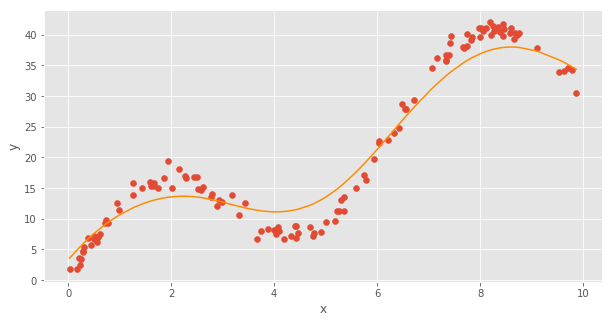

In [68]:
show_regression_line(X_test, y_test, y_pred)

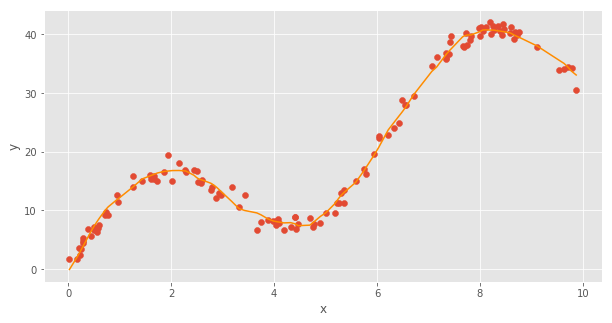

In [69]:
rgs = TorchLWLR(k=0.1).fit(X_train, y_train)
y_pred = rgs.predict(X_test)

show_regression_line(X_test, y_test, y_pred)

In [70]:
rgs.score(X_test, y_test)

0.9936454892158508

## 总结
1. 高阶API
    > * 1.1 计算loss
        >> ```python
        import torch.nn as nn
        criterion = nn.MSELoss(reduction="mean")  # 1. nn.MSELoss
        criterion(y, y_pred)
        import torch.nn.functional as F 
        F.mse_loss(y, y_pred) # 2. F.mse_loss
        >>```
    > * 1.2 自动求导
        >> * 1.2.1 设置模型参数为可求导
        >> ```python
        w = torch.tensor([10.], requires_grad=True) # 1.创建tensor时直接设置
        w = torch.normal(mean=0.0, std=1.0, size=[]).requires_grad_() # 2. 已创建的张量，调用tensor的requires_grad_方法修改为可导  
        >>```
        >> * 1.2.2 loss反向传播求导
        >>```python
        y_pred = x @ w
        loss = F.mse_loss(y, y_pred)
        loss.backward()
        w.grad
        >>```
    > * 1.3 优化器（更新参数）
        >> ```python
        learning_rate = 0.1
        optimizer = torch.optim.SGD(params=[w], lr=learning_rate)
        y_pred = x @ w
        optimizer.zero_grad() # 计算loss前一定记得梯度清理
        loss = F.mse_loss(y, y_pred)
        loss.backward()
        optimizer.step()
        >> ```
    > * 1.4 加载数据集  
        >> * 继承torch.utils.data.Dataset，重写__getitem__和__len__两个方法。  
        >> ```python
        class TorchBaseDataset(Dataset):
            def __init__(self, X_data, y_data):
                self.X_data = X_data
                self.y_data = y_data
            def __getitem__(self, index):
                return self.X_data[index], self.y_data[index]
            def __len__(self):
                return self.y_data.shape[0]
        >>```  
    > * 1.5 生成batch  
        >> ```python
        batch_size = 32
        train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        >>```
    > * 1.6 切分数据集
        >>```python
        X_data, y_data = load_linear_data(point_count=100)
        dataset = TorchBaseDataset(X_data, y_data)
        dataset_size = len(dataset)
        train_size = int(dataset_size * 0.8)
        valid_size = dataset_size - train_size
        train_dataset, valid_dataset = random_split(dataset, lengths=[train_size, valid_size])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        >>```   
    > * 1.7 正则化  
        >> * optimizer设置正则率参数weight_decay，只支持l2正则
        >>```python
        w = torch.tensor([10.], requires_grad=True)
        optimizer = torch.optim.SGD(params=[w], lr=learning_rate, weight_decay=0.01) # default l2 regularize
        >>```
        >> * 自定义正则项
        >>```python
        def l2_term(w):
            return torch.sum(torch.square(w))
        def l1_term(w):
            return torch.sum(torch.abs(w))
        #loss = loss + l2_term(w)
        >>```
    > * 1.8 nn.Linear
        
2. 基础API
    > * 2.1. torch.tensor(data, dtype=None, device=None, requires_grad=False)
        >> * torch.tensor是用data的拷贝生成Tensor
        >> * 适用于data为list，np.ndarray一般是数据较大，不用拷贝  
        >> * 不设置dtype，默认和data的数据类型一致。
    > * 2.2 torch.as_tensor(data, dtype=None, device=None)
        >> * 用data的引用生成Tensor
        >> * 适用于data为np.ndarray
        >> * 不设置dtype，默认和data的np数据类型一致。
    > * 2.3 torch.Tensor()
        >> * 是一个类，是torch.FloatTensor的别名。 
        >> * 不建议直接用torch.Tensor()实例化tensor。
        >> * 不能设置数据类型，默认torch.float32
        >> * 调用tensor.numpy()获得numpy类型值， 当tensor是标量是可调用tensor.item()获取数值。
        >> * requires_grad属性为True的tensor才可自动求导。
        >> * 调用tensor.requires_grad_()方法将不可导张量改为可导。  
        >> * tensor.T属性获取tensor的转置
    > * 2.4 torch.manual_seed(seed)
        >> * 设置random seed
    > * 2.5 torch.randn(*size, dtype, requires_grad=False, device)
        >> * 标准正态分布生成tensor
    > * 2.6 torch.ones(*size, dtype=None, requires_grad=False, device)
        >> * 生成全为1的tensor
        >> * 类似的还有torch.zeros()，生成全0tensor
    > * 2.7 torch.cat(tensors, dim=0)
        >> * 合并多个张量，多个tensor用tuple打包
    > * 2.8 torch.inverse(input)
        >> * 求逆矩阵
        >> * 奇异矩阵抛RuntimeError异常  
    > * 2.9 torch.eye(n, m=None, out=None, dtype=None)
        >> * 生成对角线为1，其他全为0的矩阵（不一定是方阵）。
        >> * m为None时，或者n = m时，生成的是单位矩阵（方阵）。  
    > * 2.10 torch.matmul(input, other)
        >> * 矩阵乘法
        >> * 可以用@运算符替代
    > * 2.11 torch.normal(mean, std, size)
        >> * 高斯分布生成数据
    > * 2.12 torch.exp(input)
        >> * 指数幂

3. 坑
    > * 3.1 torch.manual_seed(seed)设置random seed  
    > * 3.2 tensor.numpy()不能获取标量数值，用item()  
    > * 3.3 numpy里的axis，在PyTorch用dim。  
    > * 3.4 实例化optimizer时要把模型参数传进去。  

4. SGD流程 
    >```python
    """
    for epoch in arange(epoch):
        for batch in batch_ganerator(X_train, y_train):
            1. 计算预测值y_pred_batch
            2. optimizer清理梯度
            3. 计算loss
            4. loss.backward() loss反向传播
            5. optimizer.step更新参数
            6. 计算累计平均损失，并输出
        for batch in batch_ganerator(X_valid, y_valid, shuffle=False):
            1. 计算valid累计平均损失
        1. 输出valid的累计平均损失  
        2. 保存最优参数  
        3. 判断early stopping  
    """
    > ```

## 作业  

1. 手敲两遍  
2. 搞懂每个API  
3. 对比TensorFlow和PyTorch在自动求导、更新参数、生成数据集、正则化等方面有哪些异同。

## 相关链接   

<a href="./02.1.LinearRegression.ipynb" style=""> 2.1 线性回归、岭回归、Lasso、SGD、局部加权线性回归原理</a>    
<a href="./02.2.LinearRegression-sklearn.ipynb" style=""> 2.2 sklearn中使用线性回归、岭回归、Lasso、SGD、多项式回归  </a>  
<a href="./02.3.LinearRegression-numpy.ipynb" style=""> 2.3 numpy实现线性回归、岭回归、SGD回归、LWLR</a>  
<a href="./02.4.LinearRegression-tf2.ipynb"> 2.5 TensorFlow2实现线性回归、岭回归、SGD回归、LWLR </a>  

## 项目源码  

https://github.com/LossJ     
进入后点击Statistic-Machine-Learning